In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tehranhouses-csv/tehranhouses.csv


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import  ElasticNet, Lasso, LinearRegression, Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

import joblib

import warnings
warnings.filterwarnings('ignore')

## Load and Prepare Data

In [3]:
url = "/kaggle/input/tehranhouses-csv/tehranhouses.csv"

df = pd.read_csv(url)
df.head()


,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
0,63,1,True,True,True,Shahran,1850000000,61666.67
1,60,1,True,True,True,Shahran,1850000000,61666.67
2,79,2,True,True,True,Pardis,550000000,18333.33
3,95,2,True,True,True,Shahrake Qods,902500000,30083.33
4,123,2,True,True,True,Shahrake Gharb,7000000000,233333.33


In [4]:
df.sample(5)

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
3153,77,2,False,True,True,Azarbaijan,1800000000,60000.00
1501,113,2,True,True,True,Amirabad,5080000000,169333.33
2451,51,1,False,True,True,Kahrizak,610000000,20333.33
2584,300,4,True,True,True,Tajrish,9000000000,300000.00
1357,220,3,True,True,True,Aqdasieh,35000000000,1166666.67


In [5]:
type(df)

pandas.core.frame.DataFrame

In [6]:
df.columns

Index(['Area', 'Room', 'Parking', 'Warehouse', 'Elevator', 'Address', 'Price',
       'Price(USD)'],
      dtype='object')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3479 entries, 0 to 3478
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Area        3479 non-null   object 
 1   Room        3479 non-null   int64  
 2   Parking     3479 non-null   bool   
 3   Warehouse   3479 non-null   bool   
 4   Elevator    3479 non-null   bool   
 5   Address     3456 non-null   object 
 6   Price       3479 non-null   int64  
 7   Price(USD)  3479 non-null   float64
dtypes: bool(3), float64(1), int64(2), object(2)
memory usage: 146.2+ KB


In [8]:
df.describe()

,Room,Price,Price(USD)
count,3479.000000,3.479000e+03,3.479000e+03
mean,2.079908,5.359023e+09,1.786341e+05
std,0.758275,8.099935e+09,2.699978e+05
min,0.000000,3.600000e+06,1.200000e+02
25%,2.000000,1.418250e+09,4.727500e+04
50%,2.000000,2.900000e+09,9.666667e+04
75%,2.000000,6.000000e+09,2.000000e+05
max,5.000000,9.240000e+10,3.080000e+06


In [9]:
df['Area'] = df['Area'].apply(lambda x: re.sub(',', '', x))
df["Area"] = pd.to_numeric(df["Area"] , errors='coerce')

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3479 entries, 0 to 3478
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Area        3479 non-null   int64  
 1   Room        3479 non-null   int64  
 2   Parking     3479 non-null   bool   
 3   Warehouse   3479 non-null   bool   
 4   Elevator    3479 non-null   bool   
 5   Address     3456 non-null   object 
 6   Price       3479 non-null   int64  
 7   Price(USD)  3479 non-null   float64
dtypes: bool(3), float64(1), int64(3), object(1)
memory usage: 146.2+ KB


In [11]:
df

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
0,63,1,True,True,True,Shahran,1850000000,61666.67
1,60,1,True,True,True,Shahran,1850000000,61666.67
2,79,2,True,True,True,Pardis,550000000,18333.33
3,95,2,True,True,True,Shahrake Qods,902500000,30083.33
4,123,2,True,True,True,Shahrake Gharb,7000000000,233333.33
...,...,...,...,...,...,...,...,...
3474,86,2,True,True,True,Southern Janatabad,3500000000,116666.67
3475,83,2,True,True,True,Niavaran,6800000000,226666.67
3476,75,2,False,False,False,Parand,365000000,12166.67
3477,105,2,True,True,True,Dorous,5600000000,186666.67


In [12]:

print(df.dtypes)

Area            int64
Room            int64
Parking          bool
Warehouse        bool
Elevator         bool
Address        object
Price           int64
Price(USD)    float64
dtype: object


In [13]:
df.isnull().sum()

Area           0
Room           0
Parking        0
Warehouse      0
Elevator       0
Address       23
Price          0
Price(USD)     0
dtype: int64

In [14]:

df.dropna(inplace=True)

In [15]:
df.shape

(3456, 8)

In [16]:
df['Parking'].value_counts(normalize=True)*100

Parking
True     84.751157
False    15.248843
Name: proportion, dtype: float64

In [17]:
pd.crosstab( df.Parking, df.Room )

Room,0,1,2,3,4,5
Parking,,,,,,
False,8,243,244,26,1,5
True,2,426,1699,705,69,28


In [18]:
below_85 = df[ df.Area <= 85 ]
len(below_85)

1522

In [19]:
df[ df.Area <= 85 ]["Parking"].value_counts( )

Parking
True     1104
False     418
Name: count, dtype: int64

In [20]:
df.Address.unique()

array(['Shahran', 'Pardis', 'Shahrake Qods', 'Shahrake Gharb',
       'North Program Organization', 'Andisheh', 'West Ferdows Boulevard',
       'Narmak', 'Saadat Abad', 'Zafar', 'Islamshahr', 'Pirouzi',
       'Shahrake Shahid Bagheri', 'Moniriyeh', 'Velenjak', 'Amirieh',
       'Southern Janatabad', 'Salsabil', 'Zargandeh', 'Feiz Garden',
       'Water Organization', 'ShahrAra', 'Gisha', 'Ray', 'Abbasabad',
       'Ostad Moein', 'Farmanieh', 'Parand', 'Punak', 'Qasr-od-Dasht',
       'Aqdasieh', 'Pakdasht', 'Railway', 'Central Janatabad',
       'East Ferdows Boulevard', 'Pakdasht KhatunAbad', 'Sattarkhan',
       'Baghestan', 'Shahryar', 'Northern Janatabad', 'Daryan No',
       'Southern Program Organization', 'Rudhen', 'West Pars', 'Afsarieh',
       'Marzdaran', 'Dorous', 'Sadeghieh', 'Chahardangeh', 'Baqershahr',
       'Jeyhoon', 'Lavizan', 'Shams Abad', 'Fatemi',
       'Keshavarz Boulevard', 'Kahrizak', 'Qarchak',
       'Northren Jamalzadeh', 'Azarbaijan', 'Bahar',
       'P

In [21]:
len(df.Address.unique())

192

In [22]:
round(df.Price.mean())

5379956887

In [23]:
df.groupby( 'Room' )['Price'].mean()

Room
0    7.860500e+09
1    1.707481e+09
2    3.330303e+09
3    1.093869e+10
4    2.560033e+10
5    3.373439e+10
Name: Price, dtype: float64

In [24]:
pd.set_option('display.float_format', lambda x: '%.f' % x)

In [25]:
room_parking_room_mean_df = df.groupby( ['Room','Parking'] )['Price'].mean().reset_index()
room_parking_room_mean_df

,Room,Parking,Price
0,0,False,9769750000
1,0,True,223500000
2,1,False,1139677778
3,1,True,2031368545
4,2,False,1501674180
5,2,True,3592919541
6,3,False,5107865385
7,3,True,11153730496
8,4,False,6200000000
9,4,True,25881492754


In [26]:
df2 = df.copy()

In [27]:
df2.loc[:, "Price"] =df["Price"].map('{:,.0f}'.format)

In [28]:
df2

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
0,63,1,True,True,True,Shahran,"1,850,000,000",61667
1,60,1,True,True,True,Shahran,"1,850,000,000",61667
2,79,2,True,True,True,Pardis,"550,000,000",18333
3,95,2,True,True,True,Shahrake Qods,"902,500,000",30083
4,123,2,True,True,True,Shahrake Gharb,"7,000,000,000",233333
...,...,...,...,...,...,...,...,...
3474,86,2,True,True,True,Southern Janatabad,"3,500,000,000",116667
3475,83,2,True,True,True,Niavaran,"6,800,000,000",226667
3476,75,2,False,False,False,Parand,"365,000,000",12167
3477,105,2,True,True,True,Dorous,"5,600,000,000",186667


In [29]:
df.dtypes

Area            int64
Room            int64
Parking          bool
Warehouse        bool
Elevator         bool
Address        object
Price           int64
Price(USD)    float64
dtype: object

<Figure size 800x500 with 0 Axes>

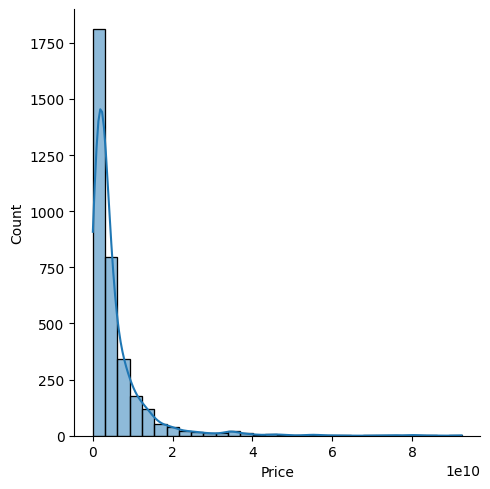

In [30]:
plt.figure(figsize=(8,5))
sns.displot(df['Price'] , bins=30 , kde=True )

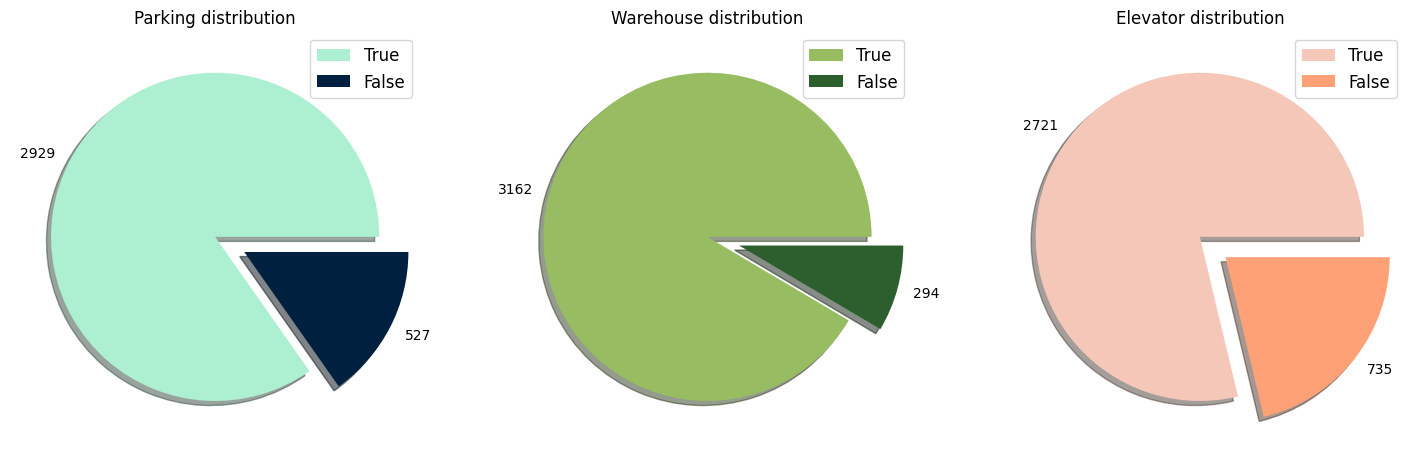

In [31]:
fig, ax = plt.subplots(ncols=3, figsize=(18,6))

colors = [['#ADEFD1FF', '#00203FFF'], ['#97BC62FF', '#2C5F2D'], ['#F5C7B8FF', '#FFA177FF']]
explode = [0, 0.2]
columns = ['Parking', 'Warehouse', 'Elevator']
for i in range(3):
        data = df[columns[i]].value_counts()
        ax[i].pie(data, labels=data.values, explode=explode, colors=colors[i], shadow=True)
        ax[i].legend(labels=data.index, fontsize='large')
        ax[i].set_title('{} distribution'.format(columns[i]))

In [32]:
df3 = df['Address'].value_counts().copy()
df3 = df3[:8]


Text(0.5, 1.0, 'Number of flats in location')

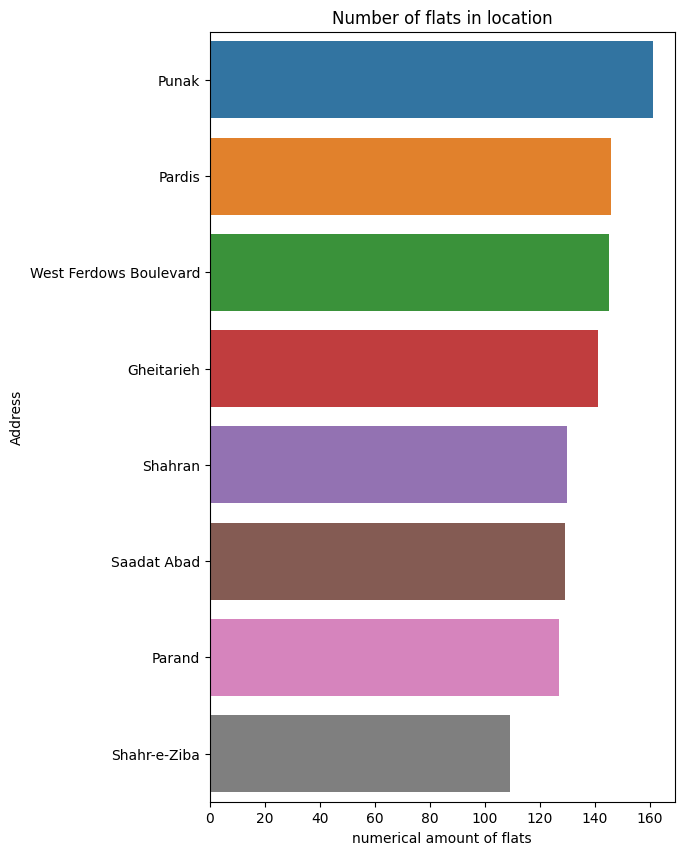

In [33]:
fig, ax = plt.subplots(figsize=(6,10))
sns.barplot(x=df3.values, y=df3.index,ax=ax)
plt.xlabel('numerical amount of flats')
plt.title('Number of flats in location')

In [34]:
df.columns

Index(['Area', 'Room', 'Parking', 'Warehouse', 'Elevator', 'Address', 'Price',
       'Price(USD)'],
      dtype='object')

In [35]:
df.sort_values('Price',ascending=False)[['Address']].head(20)

,Address
1707,Zaferanieh
1810,Abazar
430,Lavasan
819,Ekhtiarieh
1332,Niavaran
1694,Zafar
3051,Dorous
3107,Tajrish
831,Mahmoudieh
2394,Aqdasieh


In [36]:
df.isnull().sum()

Area          0
Room          0
Parking       0
Warehouse     0
Elevator      0
Address       0
Price         0
Price(USD)    0
dtype: int64

In [37]:
df

,Area,Room,Parking,Warehouse,Elevator,Address,Price,Price(USD)
0,63,1,True,True,True,Shahran,1850000000,61667
1,60,1,True,True,True,Shahran,1850000000,61667
2,79,2,True,True,True,Pardis,550000000,18333
3,95,2,True,True,True,Shahrake Qods,902500000,30083
4,123,2,True,True,True,Shahrake Gharb,7000000000,233333
...,...,...,...,...,...,...,...,...
3474,86,2,True,True,True,Southern Janatabad,3500000000,116667
3475,83,2,True,True,True,Niavaran,6800000000,226667
3476,75,2,False,False,False,Parand,365000000,12167
3477,105,2,True,True,True,Dorous,5600000000,186667


In [38]:
df = df.drop(columns = ['Price(USD)'])
boolean_features = ['Parking','Warehouse','Elevator']
df[boolean_features] = df[boolean_features].astype('int64')

df.head()

,Area,Room,Parking,Warehouse,Elevator,Address,Price
0,63,1,1,1,1,Shahran,1850000000
1,60,1,1,1,1,Shahran,1850000000
2,79,2,1,1,1,Pardis,550000000
3,95,2,1,1,1,Shahrake Qods,902500000
4,123,2,1,1,1,Shahrake Gharb,7000000000


<Axes: xlabel='Price'>

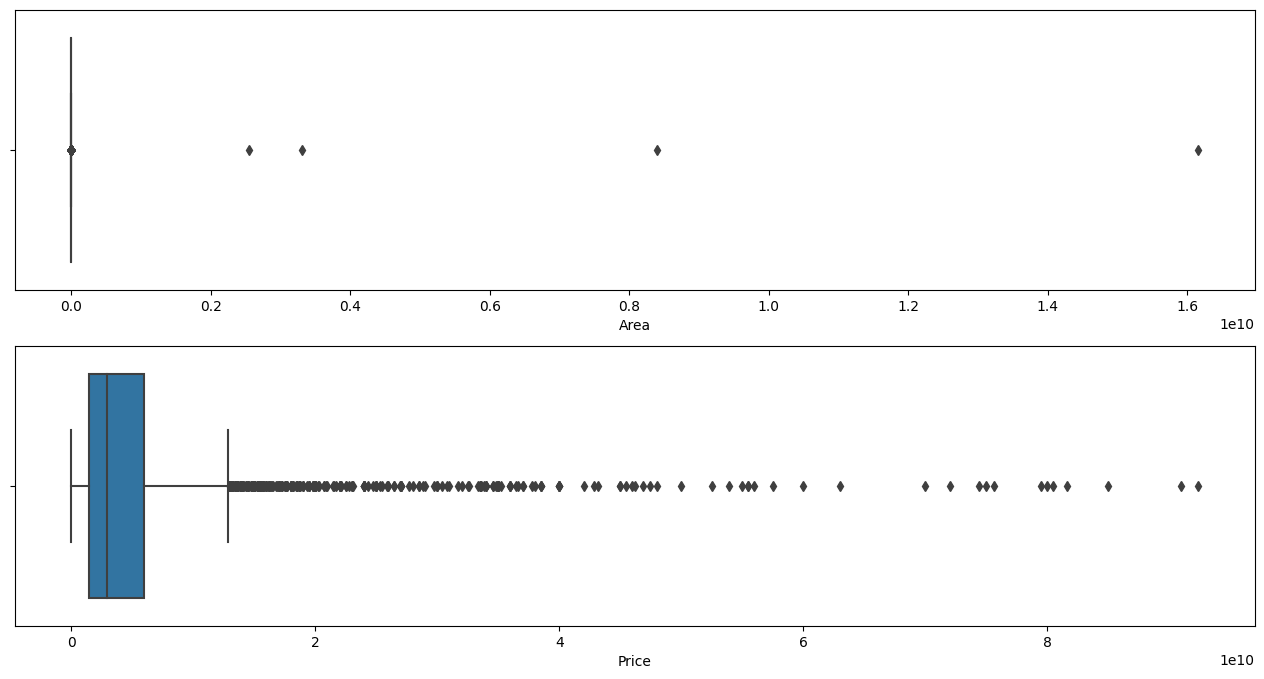

In [39]:
plt.figure(figsize = (16,8))

plt.subplot(2,1,1)
sns.boxplot(x = df['Area'])

plt.subplot(2,1,2)
sns.boxplot(x = df['Price'])

In [40]:
def lower_upper(x):
    Q1 = np.percentile(x, 25)
    Q3 = np.percentile(x, 75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    return lower, upper

lower_area, upper_area = lower_upper(df['Area'])
lower_price, upper_price = lower_upper(df['Price'])

print(f"Lower limit for area: {lower_area:0.2f}")
print(f"Upper limit for area: {upper_area:0.2f}")
print(f"Lower limit for price: {lower_price:,}")
print(f"Upper limit for price: {upper_price:,}")

Lower limit for area: -9.00
Upper limit for area: 199.00
Lower limit for price: -5,450,000,000.0
Upper limit for price: 12,870,000,000.0


In [41]:
area_outliers = np.where(df['Area'] > upper_area)
price_outliers = np.where(df['Price'] > upper_price)

total_outliers = np.union1d(area_outliers, price_outliers)

print(f"Number of area outliers: {len(df.iloc[area_outliers])}")
print(f"Number of price outliers: {len(df.iloc[price_outliers])}")
print(f"Number of outliers: {len(df.iloc[total_outliers])}")

Number of area outliers: 237
Number of price outliers: 310
Number of outliers: 366


In [42]:
total_outliers

array([  25,   58,   83,  101,  145,  159,  160,  166,  173,  176,  187,
        189,  193,  195,  196,  200,  210,  215,  218,  220,  226,  234,
        235,  238,  260,  262,  264,  269,  270,  281,  283,  284,  297,
        299,  315,  327,  329,  338,  339,  340,  342,  343,  344,  345,
        346,  347,  348,  349,  351,  353,  355,  356,  362,  363,  364,
        394,  410,  411,  412,  429,  430,  436,  439,  458,  463,  496,
        512,  514,  515,  516,  525,  534,  547,  553,  559,  564,  565,
        566,  567,  569,  572,  576,  577,  578,  579,  582,  599,  600,
        610,  627,  635,  638,  640,  641,  648,  649,  652,  706,  712,
        721,  729,  730,  731,  738,  739,  740,  753,  765,  792,  803,
        804,  816,  819,  828,  834,  836,  849,  872,  876,  891,  955,
        956,  962, 1005, 1006, 1012, 1021, 1022, 1028, 1031, 1033, 1103,
       1110, 1114, 1128, 1136, 1137, 1148, 1174, 1175, 1228, 1230, 1231,
       1232, 1258, 1260, 1265, 1266, 1270, 1282, 12

In [43]:
address_dummy = pd.get_dummies(df['Address'])
df_final = df.merge(address_dummy, left_index = True, right_index = True)
df_final.drop(columns = 'Address', inplace = True)
df_final.head(3)

,Area,Room,Parking,Warehouse,Elevator,Price,Abazar,Abbasabad,Absard,Abuzar,...,Waterfall,West Ferdows Boulevard,West Pars,Yaftabad,Yakhchiabad,Yousef Abad,Zafar,Zaferanieh,Zargandeh,Zibadasht
0,63,1,1,1,1,1850000000,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,60,1,1,1,1,1850000000,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,79,2,1,1,1,550000000,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [44]:
df_final

,Area,Room,Parking,Warehouse,Elevator,Price,Abazar,Abbasabad,Absard,Abuzar,...,Waterfall,West Ferdows Boulevard,West Pars,Yaftabad,Yakhchiabad,Yousef Abad,Zafar,Zaferanieh,Zargandeh,Zibadasht
0,63,1,1,1,1,1850000000,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,60,1,1,1,1,1850000000,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,79,2,1,1,1,550000000,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,95,2,1,1,1,902500000,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,123,2,1,1,1,7000000000,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3474,86,2,1,1,1,3500000000,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3475,83,2,1,1,1,6800000000,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3476,75,2,0,0,0,365000000,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3477,105,2,1,1,1,5600000000,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [45]:
X = df_final.drop(columns = 'Price')
y = df_final['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print(f"shape of x train: {X_train.shape}")
print(f"shape of y train: {y_train.shape}")
print(f"shape of x test: {X_test.shape}")
print(f"shape of y train: {y_test.shape}")

shape of x train: (2764, 197)
shape of y train: (2764,)
shape of x test: (692, 197)
shape of y train: (692,)


In [46]:
def parameter_finder (model, parameters):
    
    start = time.time()
    
    grid = GridSearchCV(model, 
                        param_grid = parameters, 
                        refit = True, 
                        cv = KFold(shuffle = True, random_state = 1), 
                        n_jobs = -1)
    grid_fit = grid.fit(X_train, y_train)
    y_train_pred = grid_fit.predict(X_train)
    y_pred = grid_fit.predict(X_test)
    
    train_score =grid_fit.score(X_train, y_train)
    test_score = grid_fit.score(X_test, y_test)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    
    model_name = str(model).split('(')[0]
    
    end = time.time()
    
    print(f"The best parameters for {model_name} model is: {grid_fit.best_params_}")
    print("--" * 10)
    print(f"(R2 score) in the training set is {train_score:0.2%} for {model_name} model.")
    print(f"(R2 score) in the testing set is {test_score:0.2%} for {model_name} model.")
    print(f"RMSE is {RMSE:,} for {model_name} model.")
    print("--" * 10)
    print(f"Runtime of the program is: {end - start:0.2f}")
    
       
    return train_score, test_score, RMSE

In [47]:
lr = LinearRegression(n_jobs = -1)

lr_train_score, lr_test_score, lr_RMSE = parameter_finder(lr, {})


The best parameters for LinearRegression model is: {}
--------------------
(R2 score) in the training set is 60.40% for LinearRegression model.
(R2 score) in the testing set is 53.35% for LinearRegression model.
RMSE is 6,357,973,664.868129 for LinearRegression model.
--------------------
Runtime of the program is: 3.12


In [48]:
ridge = Ridge(random_state = 1) # Linear least squares with l2 regularization.
param_ridge = {'alpha': [0.001, 0.01, 0.1, 1, 10]}

ridge_train_score, ridge_test_score, ridge_RMSE = parameter_finder(ridge, param_ridge)


/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.41786e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.41786e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.41786e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=1.41786e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:216: LinAlgWarnin

The best parameters for Ridge model is: {'alpha': 0.001}
--------------------
(R2 score) in the training set is 60.40% for Ridge model.
(R2 score) in the testing set is 53.36% for Ridge model.
RMSE is 6,357,553,945.624988 for Ridge model.
--------------------
Runtime of the program is: 0.59


In [49]:
lasso = Lasso(random_state = 1) # Linear Model trained with L1 prior as regularizer.
param_lasso = {'alpha': [0.001, 0.01, 0.1, 1, 10]}

lasso_train_score, lasso_test_score, lasso_RMSE = parameter_finder(lasso, param_lasso)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.430e+22, tolerance: 1.276e+19
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.379e+22, tolerance: 1.234e+19
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.674e+22, tolerance: 1.355e

The best parameters for Lasso model is: {'alpha': 0.001}
--------------------
(R2 score) in the training set is 60.40% for Lasso model.
(R2 score) in the testing set is 53.35% for Lasso model.
RMSE is 6,357,953,517.829563 for Lasso model.
--------------------
Runtime of the program is: 8.93


In [50]:
eln = ElasticNet(random_state = 1) 
param_eln = {'alpha': [0.001, 0.01, 0.1, 1, 10],
            'l1_ratio': [0.3, 0.4, 0.5, 0.6, 0.7]}

eln_train_score, eln_test_score, eln_RMSE = parameter_finder(eln, param_eln)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.771e+22, tolerance: 1.234e+19
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.918e+22, tolerance: 1.397e+19
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.804e+22, tolerance: 1.276e

The best parameters for ElasticNet model is: {'alpha': 0.001, 'l1_ratio': 0.7}
--------------------
(R2 score) in the training set is 59.51% for ElasticNet model.
(R2 score) in the testing set is 55.36% for ElasticNet model.
RMSE is 6,219,838,182.729824 for ElasticNet model.
--------------------
Runtime of the program is: 18.21


In [51]:
dtr = DecisionTreeRegressor(random_state = 1)
param_dtr = {'min_samples_split': [2, 3, 4, 5],
            'min_samples_leaf': [1, 2, 3]}

dtr_train_score, dtr_test_score, dtr_RMSE = parameter_finder(dtr, param_dtr)

The best parameters for DecisionTreeRegressor model is: {'min_samples_leaf': 1, 'min_samples_split': 3}
--------------------
(R2 score) in the training set is 97.91% for DecisionTreeRegressor model.
(R2 score) in the testing set is 71.37% for DecisionTreeRegressor model.
RMSE is 4,980,876,315.211948 for DecisionTreeRegressor model.
--------------------
Runtime of the program is: 1.06


In [52]:
rfr = RandomForestRegressor(random_state = 1, n_jobs = -1)
param_rfr = {'min_samples_split': [2, 3, 4, 5],
            'min_samples_leaf': [1, 2, 3]}

rfr_train_score, rfr_test_score, rfr_RMSE = parameter_finder(rfr, param_rfr)

The best parameters for RandomForestRegressor model is: {'min_samples_leaf': 1, 'min_samples_split': 3}
--------------------
(R2 score) in the training set is 94.05% for RandomForestRegressor model.
(R2 score) in the testing set is 77.55% for RandomForestRegressor model.
RMSE is 4,411,228,714.032563 for RandomForestRegressor model.
--------------------
Runtime of the program is: 41.14


In [53]:
knr = KNeighborsRegressor(n_jobs = -1)
param_knr = {'n_neighbors': [5, 10, 15, 20],
            'weights': ['uniform', 'distance']}

knr_train_score, knr_test_score, knr_RMSE = parameter_finder(knr, param_knr)

The best parameters for KNeighborsRegressor model is: {'n_neighbors': 20, 'weights': 'uniform'}
--------------------
(R2 score) in the training set is 60.39% for KNeighborsRegressor model.
(R2 score) in the testing set is 63.99% for KNeighborsRegressor model.
RMSE is 5,586,254,776.237762 for KNeighborsRegressor model.
--------------------
Runtime of the program is: 2.61


In [55]:
import joblib
joblib.dump(knr, 'knrpipe.joblib') 
model = joblib.load('knrpipe.joblib')

In [ ]:
xgboost = XGBRegressor(n_jobs = -1)
param_xgboost = {'n_estimators': [100,300],
             'learning_rate': [0.1,0.05],
             'subsample': [0.75],
             'colsample_bytree': [1],
             'max_depth': [3,4,5],
             'gamma': [0]}

xgboost_train_score, xgboost_test_score, xgboost_RMSE = parameter_finder(xgboost, param_xgboost)

In [ ]:
models_score = pd.DataFrame({'Training score': [lr_train_score, ridge_train_score, lasso_train_score, eln_train_score, dtr_train_score, rfr_train_score, knr_train_score,xgboost_train_score],
                             'Testing score': [lr_test_score, ridge_test_score, lasso_test_score, eln_test_score, dtr_test_score, rfr_test_score, knr_test_score,xgboost_test_score],
                             'RMSE': [lr_RMSE, ridge_RMSE, lasso_RMSE, eln_RMSE, dtr_RMSE, rfr_RMSE, knr_RMSE,xgboost_RMSE]},
                             index = ['LinearRegression', 'Ridge', 'Lasso','ElasticNet', 'DecisionTreeRegressor', 'RandomForestRegressor', 'KNeighborsRegressor','XGBoostRegressor'])

models_score